<a href="https://colab.research.google.com/github/Lelouch-VI-Britiania/Data-Science-Salary-Prediction/blob/main/model_selection_and_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


1. Loading data...
2. Training Models...
3. Tuning Random Forest (Wait 1-2 mins)...
4. Evaluating...
5. Generating Charts...


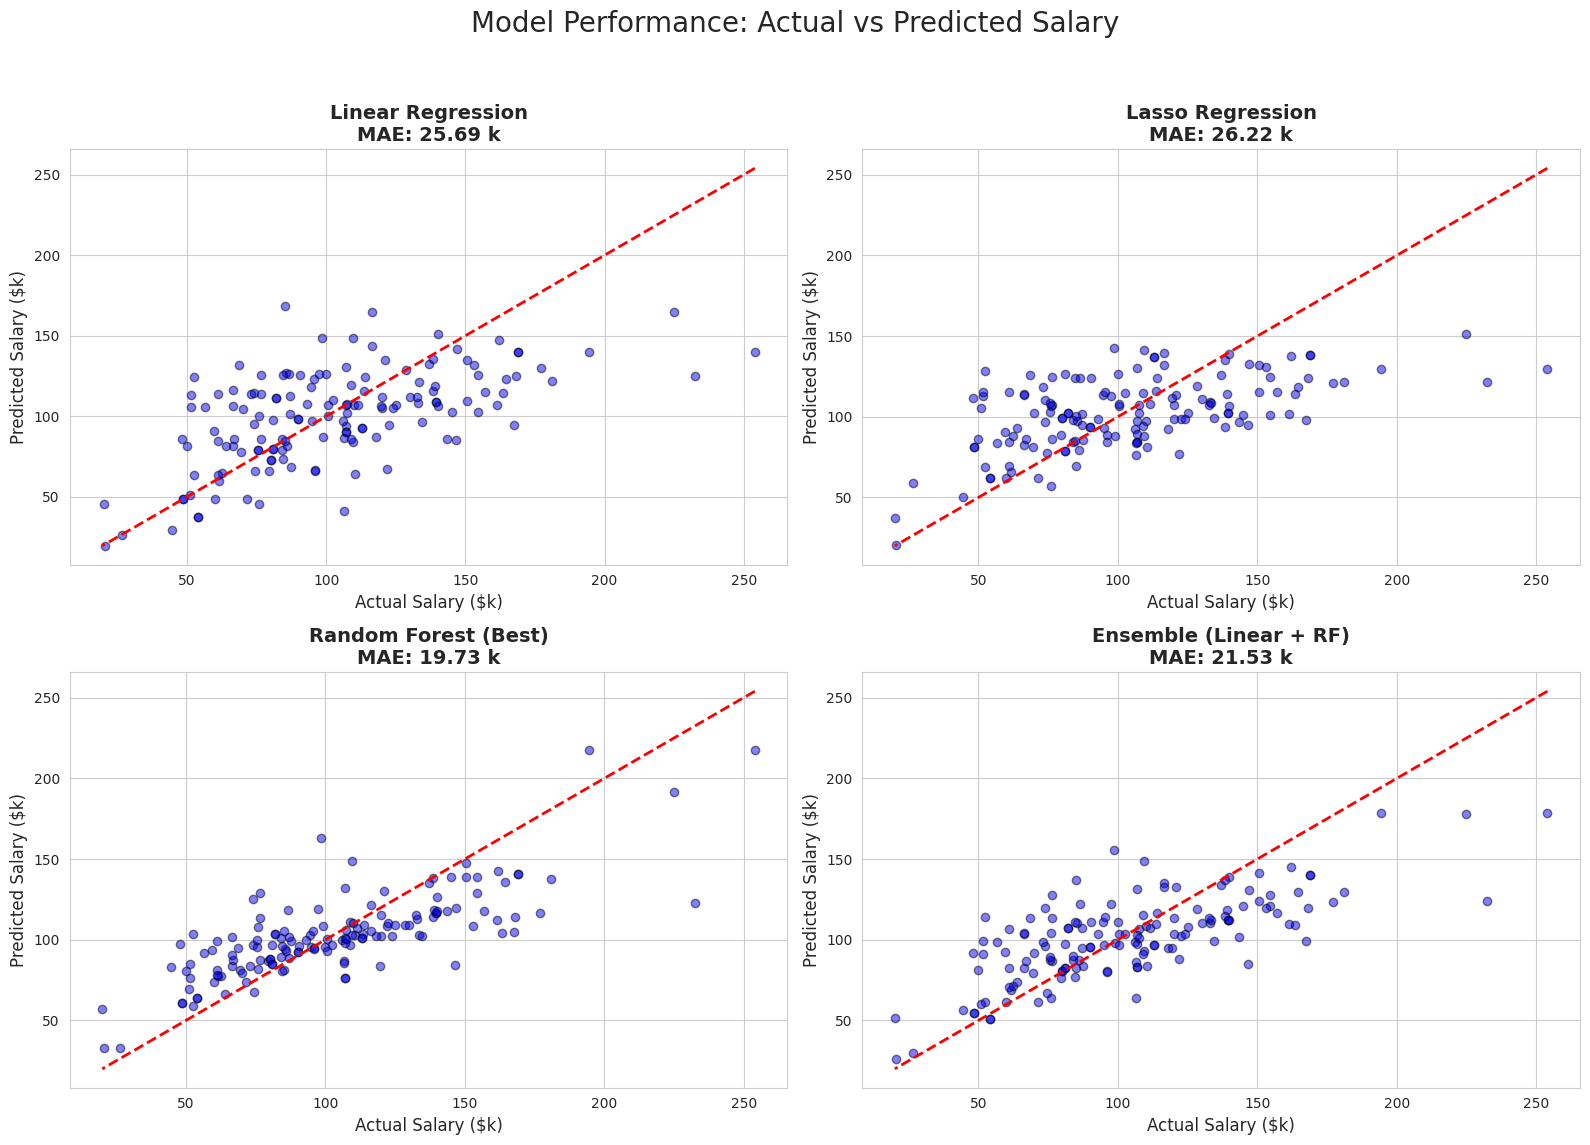

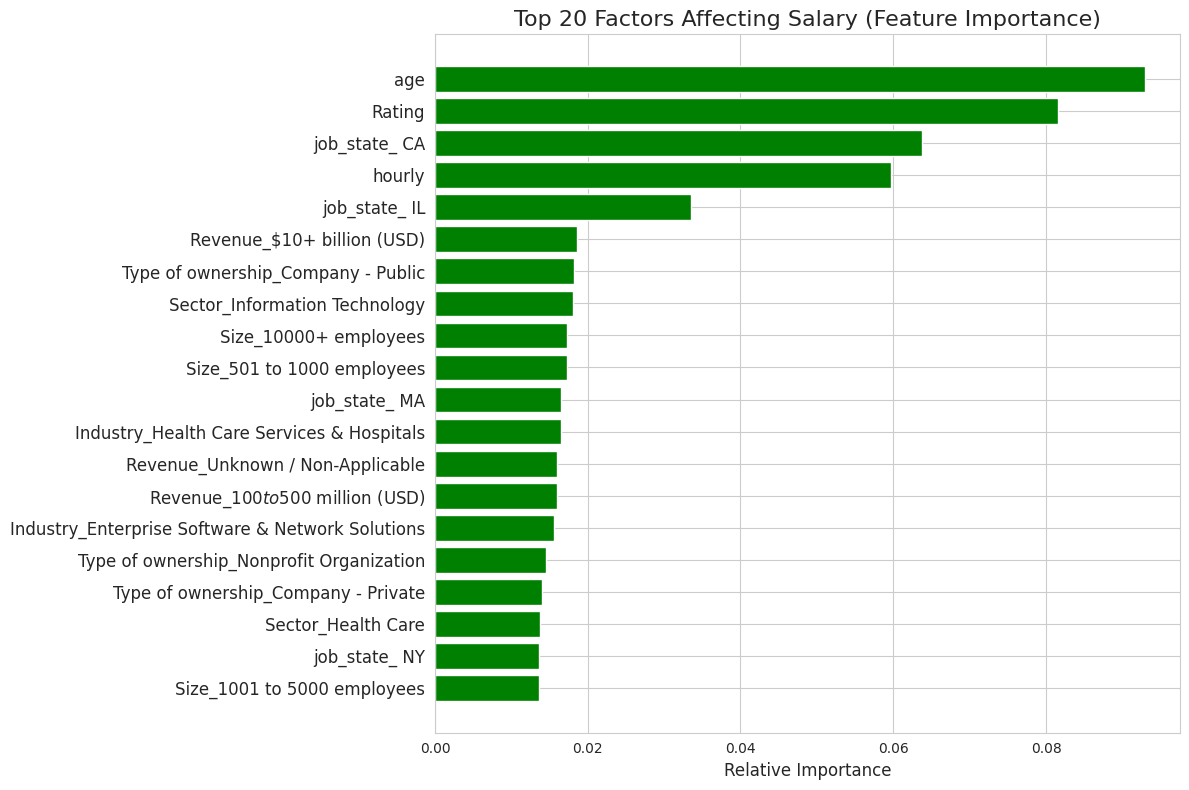

Charts generated and Model saved!


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
sns.set_style("whitegrid")
print("1. Loading data...")
path = '/content/drive/MyDrive/SalaryData_cleaned.csv'
df = pd.read_csv(path)
df_model = df[['avg_salary', 'Rating', 'Size', 'Type of ownership', 'Industry', 'Sector', 'Revenue',
               'hourly', 'employer_provided', 'job_state', 'age',
               'python_yn', 'spark_yn', 'aws_yn', 'excel_yn']]
df_dum = pd.get_dummies(df_model, dtype=int)
X = df_dum.drop('avg_salary', axis=1)
y = df_dum['avg_salary'].values
X = X.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("2. Training Models...")

lm = LinearRegression()
lm.fit(X_train, y_train)
alpha = []
error = []
for i in range(1, 100):
    tmp_alpha = i/100
    alpha.append(tmp_alpha)
    lml = Lasso(alpha=tmp_alpha)
    error.append(np.mean(cross_val_score(lml, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)))

err_tuple = tuple(zip(alpha, error))
df_err = pd.DataFrame(err_tuple, columns=['alpha', 'error'])
best_alpha = df_err.loc[df_err.error.idxmax()]['alpha']

lm_l = Lasso(alpha=best_alpha)
lm_l.fit(X_train, y_train)
print("3. Tuning Random Forest (Wait 1-2 mins)...")
rf = RandomForestRegressor(random_state=42)
parameters = {
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'max_depth': [20]
}
gs = GridSearchCV(rf, parameters, scoring='neg_mean_absolute_error', cv=3)
gs.fit(X_train, y_train)
print("4. Evaluating...")
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)
tpred_mix = (tpred_lm + tpred_rf) / 2
mae_lm = mean_absolute_error(y_test, tpred_lm)
mae_lml = mean_absolute_error(y_test, tpred_lml)
mae_rf = mean_absolute_error(y_test, tpred_rf)
mae_mix = mean_absolute_error(y_test, tpred_mix)
print("5. Generating Charts...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance: Actual vs Predicted Salary', fontsize=20)
def plot_model_result(ax, y_true, y_pred, title, mae):
    ax.scatter(y_true, y_pred, alpha=0.5, color='blue', edgecolors='k')
    p1 = max(max(y_pred), max(y_true))
    p2 = min(min(y_pred), min(y_true))
    ax.plot([p1, p2], [p1, p2], 'r--', lw=2)
    ax.set_xlabel('Actual Salary ($k)', fontsize=12)
    ax.set_ylabel('Predicted Salary ($k)', fontsize=12)
    ax.set_title(f'{title}\nMAE: {mae:.2f} k', fontsize=14, fontweight='bold')
plot_model_result(axes[0, 0], y_test, tpred_lm, "Linear Regression", mae_lm)
plot_model_result(axes[0, 1], y_test, tpred_lml, "Lasso Regression", mae_lml)
plot_model_result(axes[1, 0], y_test, tpred_rf, "Random Forest (Best)", mae_rf)
plot_model_result(axes[1, 1], y_test, tpred_mix, "Ensemble (Linear + RF)", mae_mix)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
importances = gs.best_estimator_.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12, 8))
plt.title("Top 20 Factors Affecting Salary (Feature Importance)", fontsize=16)
plt.barh(range(len(indices)), importances[indices], align='center', color='green')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=12)
plt.xlabel("Relative Importance", fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
pickl = {'model': gs.best_estimator_}
with open('model_file.p', 'wb') as f:
    pickle.dump(pickl, f)
print("Charts generated and Model saved!")